In [162]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [163]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m

In [164]:
prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

In [165]:
prices

,BTC/USDT_2024_30m,WBTC/USDT_2024_30m
timestamp,,
2024-01-01 00:00:00,42419.73,42394.30
2024-01-01 00:30:00,42475.23,42444.16
2024-01-01 01:00:00,42493.16,42431.64
2024-01-01 01:30:00,42613.56,42616.90
2024-01-01 02:00:00,42546.01,42458.23
...,...,...
2024-12-31 21:30:00,93899.68,93748.37
2024-12-31 22:00:00,93722.23,93553.89
2024-12-31 22:30:00,93488.84,93329.48


# Trading simulation
---

* ## In-Sample Testing

In [166]:
#XVS/USDT_2024_30m & QI/USDT_2024_30m
cointegrated_pairs = [('BTC/USDT_2024_30m',
  'WBTC/USDT_2024_30m',
  0.731393,
  0.8501886494196308,
  0.22)]

In [167]:
#Params:
window_size = 336
entry_threshold=3.0 
exit_threshold=0.1 
stop_loss_threshold= 4.0

In [168]:
if cointegrated_pairs:
        sym1, sym2, pass_fraction, avg_p_value,correlation = cointegrated_pairs[0]
        print(f"\nTesting strategy on pair: {sym1} and {sym2} (pass_fractioon: {pass_fraction:.4f},average_p_value: {avg_p_value:.4f} correlation: {correlation:.4f})")
        S1 = prices[sym1]
        S2 = prices[sym2]
        
        # Compute the spread series and beta_series 
        spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
        #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")
        
        # Compute rolling z-score using the provided helper function.
        zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)
        
        # Generate trading signals (positions) based on the spread's z-score
        positions_series,  win_indexs, loss_indexs, price_changes_S1, price_changes_S2 = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)
        
        #Simulate strategy performance
        #pnl, cum_pnl = simulate_strategy(S1, S2, positions, beta)
        
        #pnl, cum_pnl = simulate_true_strategy_rolling(S1, S2, positions_series, beta_series)
        


Testing strategy on pair: BTC/USDT_2024_30m and WBTC/USDT_2024_30m (pass_fractioon: 0.7314,average_p_value: 0.8502 correlation: 0.2200)
Total trades closed: 89 (Wins=79, Losses=10)
Win rate: 0.89


In [197]:
trade_profits, entry_indices, exit_indices = simulate_strategy_trade_pnl(S1, S2, positions_series, beta_series, initial_capital=1000.0)

In [198]:
#filter profits by positive values
print(np.mean(trade_profits))

1.2864909255589685


In [209]:
#filter for negative values

trade_profits_neg = [x for x in trade_profits if x < 0]
print(f"Average trade loss:  {np.mean(trade_profits_neg)}")

trade_profits_pos = [x for x in trade_profits if x > 0]
print(f"Average win profit: {np.mean(trade_profits_pos)}")

print(len(trade_profits_neg))
print(len(trade_profits_pos))


Average trade loss:  -0.5215964264605364
Average win profit: 1.5153627422702987
10
79


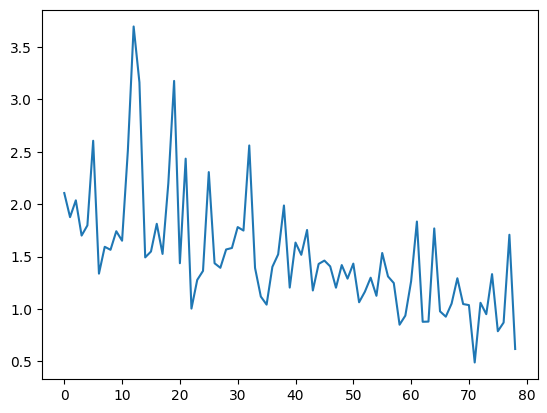

In [192]:
plt.plot(trade_profits)

In [172]:
# daily_pnl_series, cum_pnl_series, cum_pnl_pct_series, shares_S1_list, shares_S2_list = simulate_strategy_pnl(S1, S2, positions_series, beta_series=beta_series, initial_capital=1_000)

# print(f"Total PnL: {cum_pnl_series[-1]:.2f} EUR")
# print(f"Total PnL (%): {cum_pnl_pct_series[-1]:.2f}%")


In [173]:
#Obtain non-zero price changes
price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

#Convert price changes to percentage
price_changes_S1_non_zero_percent = [(x*100) for x in price_changes_S1_non_zero]
price_changes_S2_non_zero_percent = [(x*100) for x in price_changes_S2_non_zero]

#Print average price changes
print(f"Average price change S1: {np.mean(price_changes_S1_non_zero_percent)} %", f"Average price change S1: {np.mean(price_changes_S2_non_zero_percent)} %")
print(f"Number of trades: {len(price_changes_S1_non_zero)}")

Average price change S1: -0.016463855746284672 % Average price change S1: 0.2729468736880369 %
Number of trades: 88


In [174]:
len(S1)

17565

In [175]:
# len(daily_pnl_series)

In [176]:
# #Plot the cumulative PnL

# print(f"Average daily PnL (BY EXLUDING THE 0 ENTRIES): {daily_pnl_series[daily_pnl_series != 0].mean():.2f} EUR")
# print(f"Average daily PnL (%): {daily_pnl_series[daily_pnl_series != 0].mean() / 1000:.2f}%")

# #PROFIT SHOULD BE 0.15 EUR

# plt.figure(figsize=(10,6))
# plt.plot(cum_pnl_series)
# plt.title('Cumulative PnL')
# plt.xlabel('Time')
# plt.ylabel('PnL (EUR)')
# plt.show()

In [177]:
# daily_pnl_series_non_zero = [x for x in daily_pnl_series if x != 0]
# daily_pnl_series_non_zero

In [178]:
# plt.plot(daily_pnl_series)

In [179]:
# #Sum profits that dont equal zero

# daily_pnl_series[daily_pnl_series != 0].mean()


In [180]:
# #Plot trading simulation
# # window_start = '2023-10-03 00:00:00'
# # window_end = '2023-10-03 10:00:00'


# window_start = '2024-04-10 00:00:00'
# window_end = '2024-04-11 00:00:00'

# # window_start = None
# # window_end = None

# #NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES


# plot_trading_simulation(S1, S2, sym1,sym2,zscore_series, positions_series, 
#                         cum_pnl_series,win_indexs=win_indexs,loss_indexs=loss_indexs,
#                         window_start=window_start, window_end=window_end)



In [181]:
# plt.plot(spread_series.loc[window_start:window_end])
# plt.title('Spread Over Time')
# plt.legend()

In [182]:
# #zip S1 and S2 together
# S1_window = S1.loc[window_start:window_end]
# S2_window = S2.loc[window_start:window_end]

# #2023-10-23 22:43:00   -20.599535
# #compute spread

# rolling_mean_window = rolling_mean.loc[window_start:window_end]

# rolling_std_window = rolling_std.loc[window_start:window_end]

# spread_series_window = spread_series.loc[window_start:window_end]

# alpha_series_window = alpha_series.loc[window_start:window_end]

# z_score_window = zscore_series.loc[window_start:window_end]

# beta_series_window = beta_series.loc[window_start:window_end]

# #Merge dataframes together

# merged_df = pd.concat([S1_window,S2_window,spread_series_window,rolling_mean_window,rolling_std_window,alpha_series_window,z_score_window,beta_series_window],axis=1)

# merged_df.columns = ['S1','S2','Spread','Rolling Mean','Rolling Std','Alpha','Z Score','Beta']

# merged_df

In [183]:
# window_start = '2023-10-23 21:20:00'
# window_end = '2023-10-23 22:50:00'

# #Time of event: 2023-10-23 22:43:00	

# S1_window = S1[window_start:window_end]
# S2_window = S2[window_start:window_end]

# #Plot time series from window start to window end on different y axis and show data points



# fig, ax1 = plt.subplots()

# #Set size of the plot
# fig.set_size_inches(12, 8)

# color = 'tab:red'
# ax1.set_xlabel('Time')
# ax1.set_ylabel('S1', color=color)
# ax1.plot(S1_window, color=color, marker='o')
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:blue'  
# ax2.set_ylabel('S2', color=color)
# ax2.plot(S2_window, color=color, marker='o')
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Time series of S1 and S2 from window start to window end')






# # plt.plot(S1_window)
# # plt.plot(S2_window)
# # plt.title('Time series of S1 and S2 from window start to window end')
# # plt.show()

In [184]:
# spre = 31971.76 - (-2.096653) - 1.151277 * 28349.60
# spre